## 00. import data

In [20]:
import pandas as pd

data = pd.read_csv('./1024_sensor7_3sigma.csv')
data

,sensor_id,time,value,upper_limit,lower_limit,outlier_status
0,7,2024-10-24 14:52:05.428554,0.007477,0.016639,-0.001572,False
1,7,2024-10-24 14:52:05.082757,0.007776,0.016639,-0.001572,False
2,7,2024-10-24 14:52:04.73649,0.009869,0.016761,-0.001616,False
3,7,2024-10-24 14:52:04.390085,0.005682,0.016721,-0.001678,False
4,7,2024-10-24 14:52:04.045091,0.007477,0.016901,-0.001966,False
...,...,...,...,...,...,...
137808,7,2024-10-24 00:00:01.627594,0.005682,0.009572,0.004389,False
137809,7,2024-10-24 00:00:01.282146,0.007477,0.009555,0.004430,False
137810,7,2024-10-24 00:00:00.935936,0.005682,0.009548,0.004431,False
137811,7,2024-10-24 00:00:00.591811,0.006879,0.009539,0.004475,False


In [21]:
data['outlier_status'].value_counts()

outlier_status
False    137402
True        411
Name: count, dtype: int64

---

## 01. 칼만필터 적용

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from filterpy.kalman import KalmanFilter
import numpy as np

In [28]:
def apply_kalman_filter(data_values):
    # 1차원 칼만 필터 설정
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])       # 초기 상태 (위치, 속도)
    kf.F = np.array([[1., 1.],      # 상태 전이 행렬
                     [0., 1.]])
    kf.H = np.array([[1., 0.]])     # 관측 행렬
    kf.P *= 1000.                   # 초기 상태 공분산
    kf.R = 5                        # 관측 노이즈 공분산
    kf.Q = np.array([[0.001, 0.001], # 프로세스 노이즈 공분산
                     [0.001, 0.001]])

    filtered_values = []

    for value in data_values:
        kf.predict()
        kf.update([value])
        filtered_values.append(kf.x[0])  # 필터링된 위치 값을 저장

    return filtered_values

data['kalman_value'] = apply_kalman_filter(data['value'].values)

In [32]:
# 상한선, 하한선 및 이상치 여부를 계산하는 함수
def detect_outliers_with_limits(data, window_size=100):
    upper_limits = []
    lower_limits = []
    outliers = []

    for i in range(len(data)):
        if i < window_size:
            # 이전 100개의 데이터가 없으면 현재까지의 데이터로 계산
            window_data = data[:i+1]
        else:
            # 이전 100개의 데이터를 사용하여 평균 및 표준편차 계산
            window_data = data[i-window_size:i]

        mean = np.mean(window_data)
        std = np.std(window_data)

        upper_limit = mean + 5 * std
        lower_limit = mean - 5 * std

        upper_limits.append(upper_limit)
        lower_limits.append(lower_limit)

        # 이상치 여부 판단
        if data[i] > upper_limit or data[i] < lower_limit:
            outliers.append(True)
        else:
            outliers.append(False)

    return upper_limits, lower_limits, outliers

# 칼만 필터가 적용된 데이터를 이용해 상한선/하한선 및 이상치 탐지
data['upper_limit'], data['lower_limit'], data['is_outlier'] = detect_outliers_with_limits(data['kalman_value'])

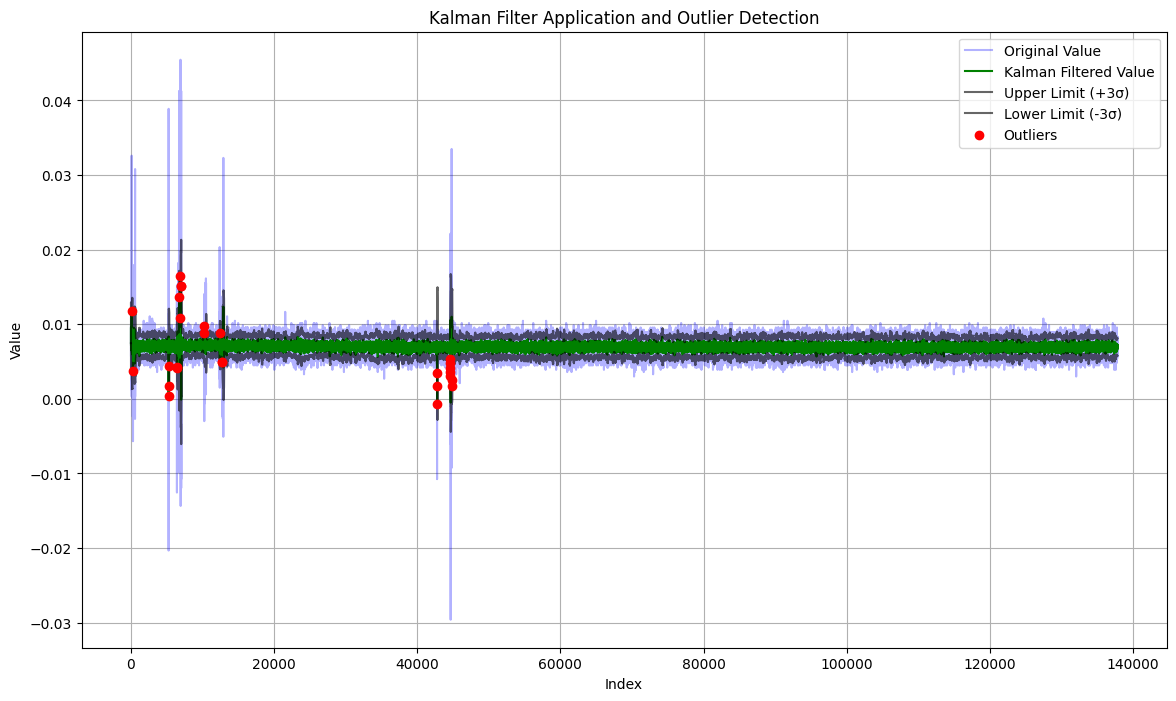

In [33]:
# 시각화: 칼만 필터 적용 전/후 비교, 상한선/하한선 및 이상치 표시
plt.figure(figsize=(14, 8))

# 원본 데이터 (필터 적용 전) - 파란색, 투명도 추가
sns.lineplot(x=data.index, y=data['value'], label='Original Value', color='blue', alpha=0.3)

# 칼만 필터가 적용된 데이터 (필터 적용 후) - 초록색, 투명도 추가
sns.lineplot(x=data.index, y=data['kalman_value'], label='Kalman Filtered Value', color='green')

# 상한선과 하한선 - 주황색 실선
sns.lineplot(x=data.index, y=data['upper_limit'], label='Upper Limit (+3σ)', linestyle='-', color='black', alpha=0.6)
sns.lineplot(x=data.index, y=data['lower_limit'], label='Lower Limit (-3σ)', linestyle='-', color='black', alpha=0.6)

# 이상치 시각화 - 빨간색 점, 크기 조절 (s=20)
outliers = data[data['is_outlier']]
plt.scatter(outliers.index, outliers['kalman_value'], color='red', label='Outliers', zorder=5)

plt.title('Kalman Filter Application and Outlier Detection')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


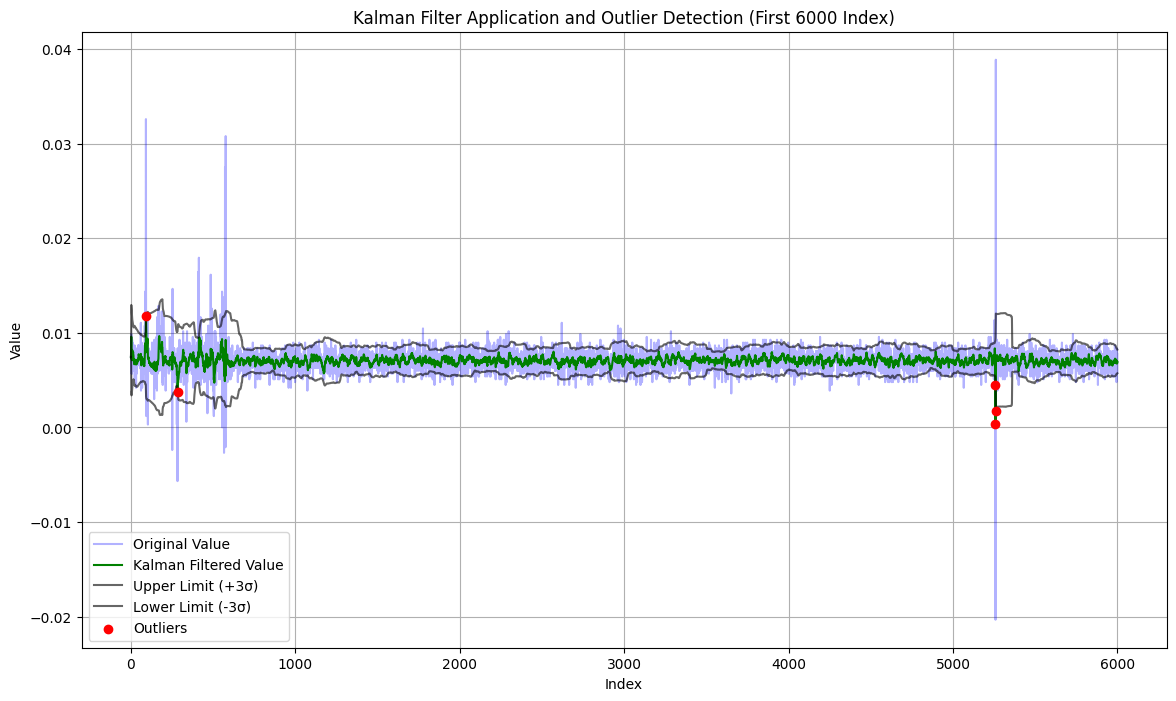

In [34]:
# 6000번째 인덱스까지만 데이터 슬라이싱
data_subset = data.iloc[:6000]

# 시각화: 칼만 필터 적용 전/후 비교, 상한선/하한선 및 이상치 표시
plt.figure(figsize=(14, 8))

# 원본 데이터 (필터 적용 전) - 파란색, 투명도 추가
sns.lineplot(x=data_subset.index, y=data_subset['value'], label='Original Value', color='blue', alpha=0.3)

# 칼만 필터가 적용된 데이터 (필터 적용 후) - 초록색, 투명도 추가
sns.lineplot(x=data_subset.index, y=data_subset['kalman_value'], label='Kalman Filtered Value', color='green')

# 상한선과 하한선 - 주황색 실선
sns.lineplot(x=data_subset.index, y=data_subset['upper_limit'], label='Upper Limit (+3σ)', linestyle='-', color='black', alpha=0.6)
sns.lineplot(x=data_subset.index, y=data_subset['lower_limit'], label='Lower Limit (-3σ)', linestyle='-', color='black', alpha=0.6)

# 이상치 시각화 - 빨간색 점, 크기 조절 (s=20)
outliers_subset = data_subset[data_subset['is_outlier']]
plt.scatter(outliers_subset.index, outliers_subset['kalman_value'], color='red', label='Outliers', zorder=5)

plt.title('Kalman Filter Application and Outlier Detection (First 6000 Index)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


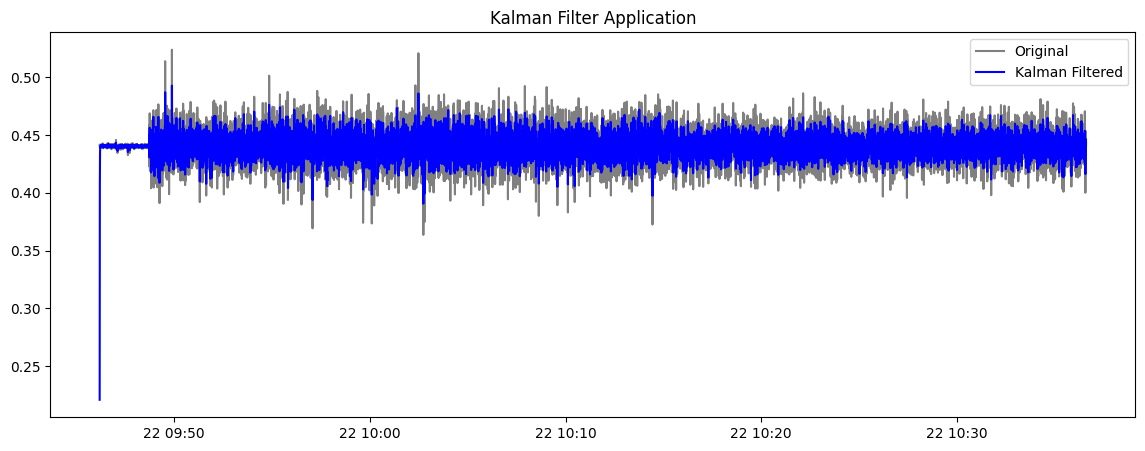

In [22]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

# 칼만 필터 초기화
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# 칼만 필터로 추정된 값
state_means, _ = kf.filter(data_half['value'].values)

# 필터링 결과 시각화
plt.figure(figsize=(14, 5))
plt.plot(data_half.index, data_half['value'], label='Original', color='gray')
plt.plot(data_half.index, state_means, label='Kalman Filtered', color='blue')
plt.title('Kalman Filter Application')
plt.legend()
plt.show()

# 칼만 필터 적용 후 데이터로 교체
filtered_data = state_means

---

## ARIMA 적용 가능여부 파악 (정상성)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [62]:
data = pd.read_csv('./sample_data.csv')
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

In [63]:
# 2. ADF 정상성 검사
result = adfuller(data['value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print("데이터가 정상성을 띠지 않음. 추가적인 차분이 필요할 수 있음.")
else:
    print("데이터가 정상성을 띰.")

ADF Statistic: -3.4138248619084703
p-value: 0.01049651501635619
데이터가 정상성을 띰.


데이터가 정상성을 띠기 때문에 arima 예측모델 사용하기에 good.

---

## 모델링 시행착오

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 데이터 불러오기 (이미 data가 있으므로 불러올 필요 없음)

# 칼만 필터 적용된 'kalman_value' 칼럼을 예측 대상으로 설정
values = data['kalman_value'].values

# 데이터 정규화 (LSTM에 입력하기 전에 스케일링 작업)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values.reshape(-1, 1))

# 시계열 데이터로 변환하는 함수 (LSTM은 과거 데이터를 사용하여 예측)
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# 시퀀스 길이 정의 (예: 50개 시점의 데이터를 사용하여 다음 값을 예측)
sequence_length = 50
X, y = create_sequences(scaled_values, sequence_length)

# train/test 데이터 나누기 (예: 80% 훈련, 20% 테스트)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM에 입력하기 위해 3D 형태로 reshape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### 2. LSTM 모델 구성 및 훈련

# LSTM 모델 구성
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

### 3. 예측 및 시각화

# 테스트 세트로 예측
predicted_values = model.predict(X_test)

# 예측된 값 역정규화 (원래 스케일로 복원)
predicted_values = scaler.inverse_transform(predicted_values)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 시각화
plt.figure(figsize=(14, 8))

# 실제 값 (테스트 데이터)
plt.plot(data.index[-len(y_test):], y_test, label='Actual Kalman Value', color='blue')

# 예측 값 (LSTM 모델)
plt.plot(data.index[-len(predicted_values):], predicted_values, label='Predicted Kalman Value', color='green')

plt.title('LSTM Prediction of Kalman Filtered Data')
plt.xlabel('Time')
plt.ylabel('Kalman Value')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# 3. ARIMA 모델 학습 및 예측
# 데이터 나누기 (70% 학습, 30% 테스트)
train_size = int(len(data) * 0.7)
train, test = data['value'][:train_size], data['value'][train_size:]

# ARIMA 모델 학습
model = ARIMA(train, order=(5,1,0))  # ARIMA(p=5, d=1, q=0)
model_fit = model.fit()

# 테스트 데이터에 대해 예측
forecast = model_fit.forecast(steps=len(test))

/home/osanie/.conda/envs/jsys/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/osanie/.conda/envs/jsys/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/osanie/.conda/envs/jsys/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/osanie/.conda/envs/jsys/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

In [15]:
# 4. Auto ARIMA 사용
auto_model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
auto_model.fit(train)
forecast_auto = auto_model.predict(n_periods=len(test))

/home/osanie/.conda/envs/jsys/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/osanie/.conda/envs/jsys/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [16]:
# 5. SARIMA 모델 학습 및 예측
sarima_model = SARIMAX(train, order=(5, 1, 0), seasonal_order=(1, 1, 0, 12))
sarima_model_fit = sarima_model.fit()
forecast_sarima = sarima_model_fit.forecast(steps=len(test))

/home/osanie/.conda/envs/jsys/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/osanie/.conda/envs/jsys/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.97542D+00    |proj g|=  6.58969D+00


 This problem is unconstrained.



At iterate    5    f= -1.99429D+00    |proj g|=  4.91532D-02

At iterate   10    f= -1.99477D+00    |proj g|=  8.97789D-01

At iterate   15    f= -1.99520D+00    |proj g|=  2.62833D-02

At iterate   20    f= -1.99538D+00    |proj g|=  3.20738D-03

At iterate   25    f= -1.99538D+00    |proj g|=  5.00346D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     39      1     0     0   7.328D-03  -1.995D+00
  F =  -1.9953846639326238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/osanie/.conda/envs/jsys/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/osanie/.conda/envs/jsys/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [17]:
# 예측 성능 평가 (MSE)
mse_arima = mean_squared_error(test, forecast)
mse_auto_arima = mean_squared_error(test, forecast_auto)
mse_sarima = mean_squared_error(test, forecast_sarima)

print(f"ARIMA Mean Squared Error: {mse_arima}")
print(f"Auto ARIMA Mean Squared Error: {mse_auto_arima}")
print(f"SARIMA Mean Squared Error: {mse_sarima}")

ARIMA Mean Squared Error: 0.0002082107194888488
Auto ARIMA Mean Squared Error: 0.0002049441472072651
SARIMA Mean Squared Error: 0.6112143241721364


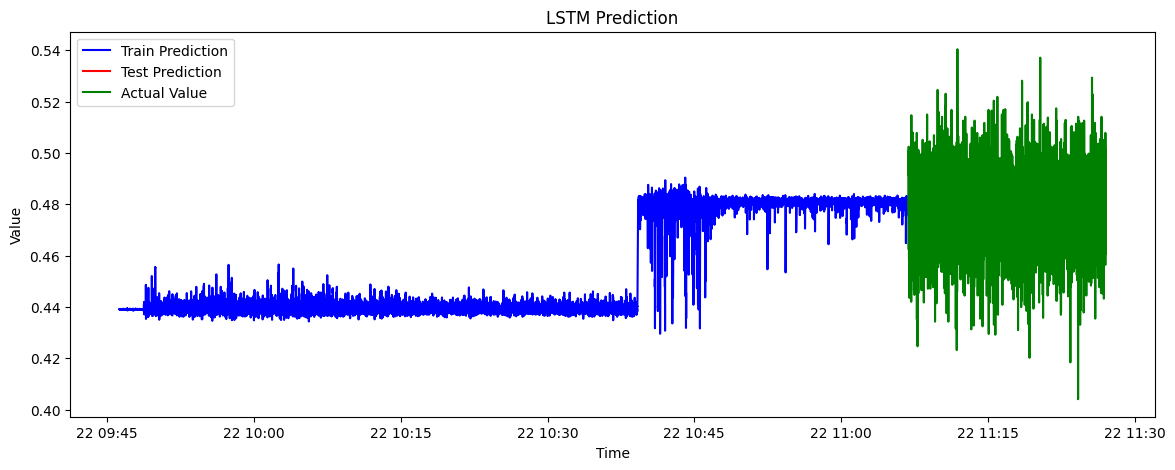

In [2]:
# 결과 시각화
plt.figure(figsize=(14, 5))

# 훈련 예측 결과
plt.plot(data.index[time_step:train_size + time_step], train_predict, label='Train Prediction', color='blue')

# 테스트 예측 결과 (인덱스 수정)
plt.plot(data.index[train_size + time_step:train_size + time_step + len(test_predict)], test_predict, label='Test Prediction', color='red')

# 실제 값 (인덱스 수정)
plt.plot(data.index[train_size + time_step:train_size + time_step + len(y_test_actual)], y_test_actual, label='Actual Value', color='green')

plt.title('LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [3]:
# 성능 평가 (MSE)
mse = mean_squared_error(y_test_actual, test_predict)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.00021696879839792874
